In [60]:
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras import Sequential, optimizers, preprocessing, initializers
from tensorflow.keras.layers import MaxPooling2D, Dense, BatchNormalization, Dropout, Flatten, InputLayer, Conv2D, Activation
import tensorflow as tf
from tensorflow.python.keras import backend as K
from sklearn import preprocessing, model_selection, metrics
from math import ceil
import pandas as pd
import numpy as np
from skimage import io
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
import seaborn as sns
from matplotlib import pyplot as plt
from shutil import copyfile

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

GPU is available


In [2]:
class BatchGenerator(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([preprocessing.StandardScaler().fit_transform(io.imread(os.path.join(PATH, file_name))).reshape(
            (400, 400, 1))
                         for file_name in batch_x]), np.array(batch_y)



In [5]:
batch_size = 32

In [6]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")

In [8]:
PATH = os.path.join("dataset", "test")
df = pd.read_csv(os.path.join("dataset", "test.csv"), index_col=0)
X = df.filename.values
Y = pd.get_dummies(df.label)

In [9]:
test_batch_generator = BatchGenerator(X, Y, batch_size=batch_size)
predicts_labels = np.argmax(model.predict(test_batch_generator), axis=1)

In [10]:
metrics.accuracy_score(np.argmax(Y.values, axis=1), predicts_labels)

0.799375

In [12]:
predicts_labels_image = [np.bincount(row).argmax() for row in predicts_labels.reshape(400, 4)]
true_labels_image = [np.bincount(row).argmax() for row in np.argmax(Y.values, axis=1).reshape(400, 4)]

In [13]:
metrics.accuracy_score(true_labels_image, predicts_labels_image)

0.8225

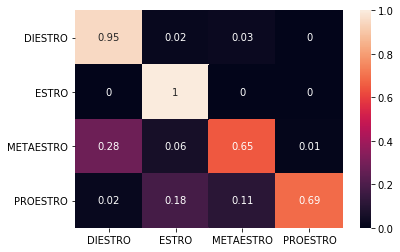

In [41]:
confusion_matrix = metrics.confusion_matrix(true_labels_image, predicts_labels_image, normalize="true")
confusion_matrix = pd.DataFrame(data=confusion_matrix, columns=['DIESTRO', 'ESTRO', 'METAESTRO', 'PROESTRO'], 
                  index=['DIESTRO', 'ESTRO', 'METAESTRO', 'PROESTRO'])

sns.heatmap(confusion_matrix, annot=True)

# Wrong predictions

In [29]:
labels = df.label.unique()
mask = np.argmax(Y.values, axis=1) != predicts_labels
wrongs = df[mask]
wrongs["predict"] = [labels[predict_label] for predict_label in predicts_labels[mask]]

C:\Users\Rafa\Miniconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [49]:
wrongs

,filename,label,predict
2,DIESTRO_D001.jpg_2.jpg,DIESTRO,PROESTRO
9,DIESTRO_D003.jpg_1.jpg,DIESTRO,PROESTRO
10,DIESTRO_D003.jpg_2.jpg,DIESTRO,PROESTRO
15,DIESTRO_D004.jpg_3.jpg,DIESTRO,ESTRO
35,DIESTRO_D009.jpg_3.jpg,DIESTRO,METAESTRO
...,...,...,...
1595,PROESTRO_P099.jpg_3.jpg,PROESTRO,ESTRO
1596,PROESTRO_P100.jpg_0.jpg,PROESTRO,ESTRO
1597,PROESTRO_P100.jpg_1.jpg,PROESTRO,ESTRO
1598,PROESTRO_P100.jpg_2.jpg,PROESTRO,ESTRO


In [46]:
wrongs[(wrongs.label=="DIESTRO") & (wrongs.predict == "ESTRO")].shape[0]

19

In [47]:
wrongs[(wrongs.label=="PROESTRO") & (wrongs.predict == "ESTRO")].shape[0]

73

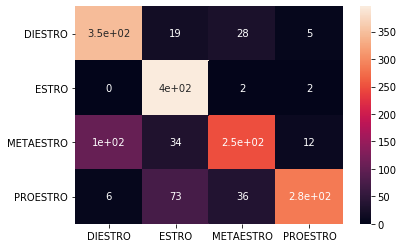

In [43]:
confusion_matrix = metrics.confusion_matrix(np.argmax(Y.values, axis=1), predicts_labels)
confusion_matrix = pd.DataFrame(data=confusion_matrix, columns=['DIESTRO', 'ESTRO', 'METAESTRO', 'PROESTRO'], 
                  index=['DIESTRO', 'ESTRO', 'METAESTRO', 'PROESTRO'])

sns.heatmap(confusion_matrix, annot=True)

In [58]:
wrongs.to_csv(os.path.join("dataset", "wrongs_predictions.csv"))

In [59]:
for filename, true_label, wrong_label in wrongs.to_numpy():
    path = os.path.join("dataset", "wrongs_predictions", true_label, wrong_label)
    os.mkdir(path)
    os.m

array([['DIESTRO_D001.jpg_2.jpg', 'DIESTRO', 'PROESTRO'],
       ['DIESTRO_D003.jpg_1.jpg', 'DIESTRO', 'PROESTRO'],
       ['DIESTRO_D003.jpg_2.jpg', 'DIESTRO', 'PROESTRO'],
       ['DIESTRO_D004.jpg_3.jpg', 'DIESTRO', 'ESTRO'],
       ['DIESTRO_D009.jpg_3.jpg', 'DIESTRO', 'METAESTRO'],
       ['DIESTRO_D011.jpg_3.jpg', 'DIESTRO', 'METAESTRO'],
       ['DIESTRO_D018.jpg_2.jpg', 'DIESTRO', 'ESTRO'],
       ['DIESTRO_D018.jpg_3.jpg', 'DIESTRO', 'ESTRO'],
       ['DIESTRO_D019.jpg_3.jpg', 'DIESTRO', 'METAESTRO'],
       ['DIESTRO_D020.jpg_2.jpg', 'DIESTRO', 'METAESTRO'],
       ['DIESTRO_D026.jpg_0.jpg', 'DIESTRO', 'METAESTRO'],
       ['DIESTRO_D030.jpg_2.jpg', 'DIESTRO', 'METAESTRO'],
       ['DIESTRO_D033.jpg_0.jpg', 'DIESTRO', 'ESTRO'],
       ['DIESTRO_D033.jpg_1.jpg', 'DIESTRO', 'METAESTRO'],
       ['DIESTRO_D033.jpg_2.jpg', 'DIESTRO', 'METAESTRO'],
       ['DIESTRO_D034.jpg_1.jpg', 'DIESTRO', 'ESTRO'],
       ['DIESTRO_D035.jpg_0.jpg', 'DIESTRO', 'METAESTRO'],
       ['DIESTRO_D03

In [74]:
root = os.getcwd()
for label in wrongs.label.unique():
    for wrong_label in wrongs.predict.unique():
        if label != wrong_label:
            path = os.path.join(root, "dataset", "wrongs_predictions", "true_"+label, "wrong_"+wrong_label)
            os.makedirs(path)
            for filename in wrongs[(wrongs.label==label) & (wrongs.predict == wrong_label)].filename:
                copyfile(os.path.join(root, "dataset", "test", filename), os.path.join(path, filename))

In [69]:
os.getcwd()

'M:\\cell-datasets'

In [75]:
wrongs.label.unique()

array(['DIESTRO', 'ESTRO', 'METAESTRO', 'PROESTRO'], dtype=object)